In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
os.getcwd()

'/Users/tessa/Desktop/Online_Courses/Udacity/DS Nanodegree'

In [23]:
main_df = pd.read_csv('developer_survey_2020/survey_results_public.csv')
schema = pd.read_csv('developer_survey_2020/survey_results_schema.csv')

In [24]:
max(main_df.Respondent)

65639

In [28]:
#limit only to the participants in US and doing data related jobs to eliminate confounding factors
main_df = main_df[main_df['Country']=='United States']
main_df.dropna(axis=0,subset=['DevType'], inplace = True)
main_df = main_df[main_df.DevType.str.contains('Data|data')]

In [31]:
main_df.DevType.head()

26    Database administrator;Developer, full-stack;E...
56    Database administrator;Designer;Developer, bac...
71    Data or business analyst;Data scientist or mac...
76    Academic researcher;Data scientist or machine ...
99    Database administrator;Designer;Developer, ful...
Name: DevType, dtype: object

In [29]:
main_df.shape

(2757, 61)

Text(0.5,0,'Percentage')

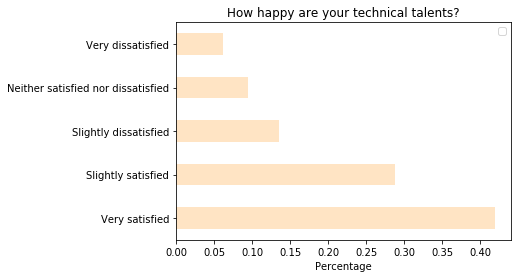

In [32]:
job_sat = main_df['JobSat'].value_counts().reset_index()
job_sat['perc'] = job_sat['JobSat']/sum(job_sat['JobSat'])
job_sat = pd.DataFrame({'perc': list(job_sat['perc'])}, index=job_sat['index'])
job_sat.plot.barh(y='perc', color=['bisque'])
plt.title("How happy are your technical talents?")
plt.ylabel("")
plt.legend("")
plt.xlabel("Percentage")

Text(0.5,0,'Percentage')

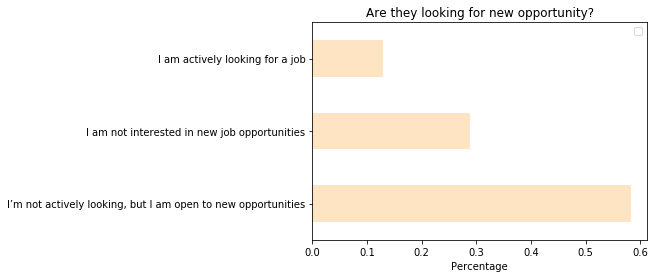

In [33]:
job_seek = main_df['JobSeek'].value_counts().reset_index()
job_seek['perc'] = job_seek['JobSeek']/sum(job_seek['JobSeek'])
job_seek = pd.DataFrame({'perc': list(job_seek['perc'])}, index=job_seek['index'])
job_seek.plot.barh(y='perc', color=['bisque'])
plt.title("Are they looking for new opportunity?")
plt.ylabel("")
plt.legend("")
plt.xlabel("Percentage")

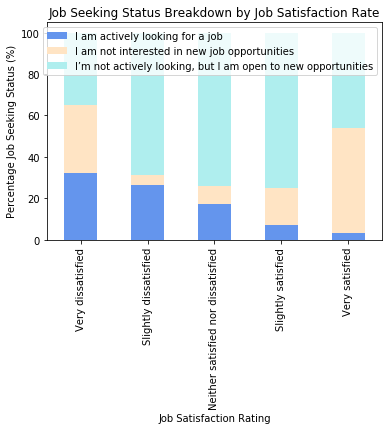

In [34]:
df_plot = main_df.groupby(['JobSeek','JobSat']).count().reset_index()[['JobSeek','JobSat','Respondent']]
df_plot_f = df_plot.pivot(index='JobSat', columns='JobSeek', values='Respondent')
sat_order = ['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied',
            'Slightly satisfied','Very satisfied']
df_plot_f = df_plot_f.reset_index()
df_plot_f = df_plot_f.set_index('JobSat').loc[sat_order]
stacked_data = df_plot_f.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, color = ['cornflowerblue','bisque','paleturquoise'])
plt.title("Job Seeking Status Breakdown by Job Satisfaction Rate")
plt.xlabel("Job Satisfaction Rating")
plt.ylabel("Percentage Job Seeking Status (%)")
plt.legend(title='')

In [ ]:
#Q1.1 what do developers care about when looking for a job, besides compensation, benifit and location

In [35]:
# a list of all possible values of job factors
job_factors = main_df['JobFactors'].value_counts().reset_index()
job_factors.rename(columns={'index': 'JobFactors', 'JobFactors': 'count'}, inplace=True)
possible_vals = ["Remote work options", "Office environment or company culture", 
                 "Financial performance or funding status of the company or organization", "Opportunities for professional development", "Return to college",
                 "Diversity of the company or organization", "How widely used or impactful my work output would be",
                 "Industry that I’d be working in", "Specific department or team I’d be working on",
                 "Flex time or a flexible schedule", "Languages, frameworks, and other technologies I’d be working with", "Family friendliness"]

In [36]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]
    
    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up 
    '''
    new_df = defaultdict(int)
    for val in look_for:
        for idx in range(df.shape[0]):
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])   
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [37]:
JobFactors_df = pd.DataFrame(total_count(job_factors, 'JobFactors', 'count', possible_vals))

In [38]:
JobFactors_df['perc'] = JobFactors_df['count']/sum(JobFactors_df['count'])

,JobFactors,count,perc
7,Office environment or company culture,1065,0.145731
6,"Languages, frameworks, and other technologies ...",1061,0.145183
3,Flex time or a flexible schedule,1000,0.136836
9,Remote work options,975,0.133415
8,Opportunities for professional development,884,0.120963
4,How widely used or impactful my work output wo...,672,0.091954
5,Industry that I’d be working in,402,0.055008
10,Specific department or team I’d be working on,400,0.054735
2,Financial performance or funding status of the...,339,0.046388
1,Family friendliness,331,0.045293


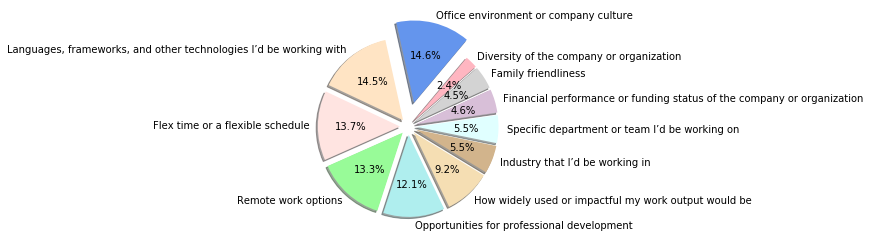

In [39]:
fig1, ax1 = plt.subplots()
ax1.pie(list(JobFactors_df['count']),explode=[0.3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], labels = list(JobFactors_df['JobFactors']),autopct='%1.1f%%',
        shadow=True, startangle=50, 
       colors = ['cornflowerblue','bisque','mistyrose','palegreen','paleturquoise','wheat','tan','lightcyan',
                'thistle','lightgrey','lightpink'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
#Q1.2 What channels do people use to do research when they are looking for a job?

In [40]:
# a list of all possible values of channels
channel = main_df['NEWJobHuntResearch'].value_counts().reset_index()
channel.rename(columns={'index': 'channel', 'NEWJobHuntResearch': 'count'}, inplace=True)
possible_vals_channel = ["Read company media, such as employee blogs or company culture videos", 
                 "Company reviews from third party sites (e.g. Glassdoor, Blind)", 
                 "Publicly available financial information (e.g. Crunchbase)", 
                 "Personal network - friends or family",
                 "Read other media like news articles, founder profiles, etc. about the company", 
                 "Directly asking current or past employees at the company",
                 "Other"]

In [41]:
channel_df = pd.DataFrame(total_count(channel, 'channel', 'count', possible_vals_channel))

In [42]:
channel_df

,channel,count
0,Company reviews from third party sites (e.g. G...,1832
2,Personal network - friends or family,1549
4,"Read company media, such as employee blogs or ...",1496
5,"Read other media like news articles, founder p...",1326
1,Directly asking current or past employees at t...,1034
3,Publicly available financial information (e.g....,854


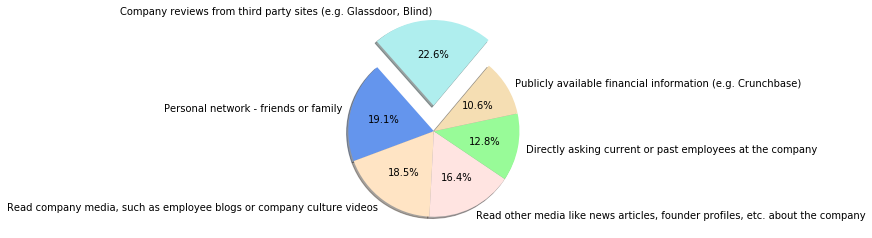

In [43]:
fig2, ax2 = plt.subplots()
ax2.pie(list(channel_df['count']),explode=[0.3,0,0,0,0,0], labels = list(channel_df['channel']),autopct='%1.1f%%',
        shadow=True, startangle=50, 
       colors = ['paleturquoise','cornflowerblue','bisque','mistyrose','palegreen','wheat'])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [44]:
#Q2 is income the only factor for satisfaction? A: there's close to no correlation between total income and job
#satisfaction
#cast satisfaction result to numeric score
cleanup_sat = {"JobSat": {"Very dissatisfied": 1, 
                          "Slightly dissatisfied": 2, 
                         "Neither satisfied nor dissatisfied":3,
                         "Slightly satisfied":4,
                          "Very satisfied":5
                         },
                }
main_df = main_df.replace(cleanup_sat)

In [45]:
#remove all the records with no JobSat info
main_df.dropna(axis=0, subset=['JobSat'], inplace=True)
main_df.ConvertedComp.fillna(main_df.ConvertedComp.mean(), inplace = True)

In [46]:
np.corrcoef(main_df['JobSat'], main_df['ConvertedComp'])

array([[ 1.        , -0.01533174],
       [-0.01533174,  1.        ]])

In [ ]:
#Q3. what is contributing to people's satisfaction towards their jobs? (ind. var: sal, Newlearn, Newovertime, WorkWeekHrs, Orgsize, Edlevel)
#to control for confounding factors, I'm running a logit regression to assess the relationship between different factors and job satisfaction

Text(0,0.5,'Count of Participants')

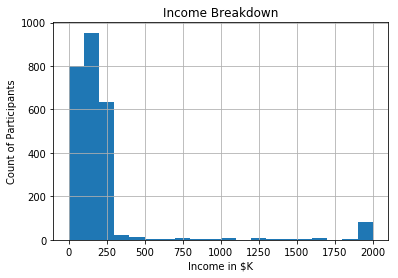

In [52]:
main_df['thousandDollar']=main_df.ConvertedComp/1000
main_df.thousandDollar.hist(bins=20)
plt.title("Income Breakdown")
plt.xlabel("Income in $K")
plt.ylabel("Count of Participants")

In [182]:
#remove all the records that are outliers (3std away)
main_df_f = main_df[main_df.ConvertedComp<=main_df.ConvertedComp.mean()+3*main_df.ConvertedComp.std()]

In [183]:
main_df_f['10kcomp'] = main_df_f['thousandDollar']/10

/Users/tessa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [184]:
#(ind. var: sal, Newlearn, Newovertime, WorkWeekHrs, Orgsize, Edlevel)
df_reg = main_df_f[['10kcomp','JobSat','WorkWeekHrs','OrgSize','Hobbyist','YearsCode','YearsCodePro','EdLevel']]

In [185]:
#convert the dependent var into 1 and 0 for logit reg
df_reg['JobSat_Cat']=0
df_reg.JobSat_Cat[df_reg.JobSat==5]=1
df_reg.drop(columns=['JobSat'], axis = 1, inplace=True)

/Users/tessa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/tessa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/tessa/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [186]:
#create dummy vars
cat_vars_int = df_reg.select_dtypes(include=['object']).copy().columns
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df_reg = pd.concat([df_reg.drop(var, axis=1), pd.get_dummies(df_reg[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [187]:
#fill nan with mean
df_reg.fillna(df_reg.mean(), inplace = True)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.542


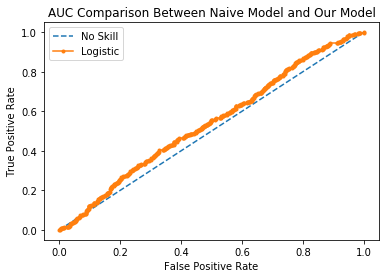

In [188]:
#plot AUC curve
y = df_reg['JobSat_Cat']
X = df_reg.drop(['JobSat_Cat'], axis=1)
weights = {0:0.4, 1:0.5}
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs', class_weight=weights)
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('AUC Comparison Between Naive Model and Our Model')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [189]:
# to better interpret the coefficients, I'm taking the exponential of the coefficients
log_odds = np.exp(model.coef_[0])
coef_results = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

In [190]:
coef_results.loc[ ['10kcomp'] , : ]
#this number can be interpreted as "for every 10K (unit we chose for income) increase, the odds for the individual to 
#be very satisfied is 1.012 more likely compare to him/her being not very satisfied"

,coef
10kcomp,1.011739


In [170]:
coef_results

,coef
OrgSize_2 to 9 employees,1.269698
"EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)",1.164688
Hobbyist_Yes,1.111597
YearsCodePro_19,1.103567
"OrgSize_Just me - I am a freelancer, sole proprietor, etc.",1.102531
YearsCode_20,1.090484
YearsCode_25,1.089320
YearsCode_3,1.084642
OrgSize_10 to 19 employees,1.081634
YearsCode_40,1.072430
